#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12666740046476892641
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5236083860949398770
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_gg.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(781, 16)
(781, 16)
(781, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

r_index: 100%|##########| 91/91 [00:00<00:00, 606.53it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(1143, 16)
(1319, 16)
(1199, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(837, 15)
(1215, 15)
(1086, 15)


StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [19]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

MinMaxScaler

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [21]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(669, 15)
(972, 15)
(868, 15)


#### 10-Fold Crossvalidation

In [22]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [23]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [24]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [25]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 14:40:22,938] A new study created in memory with name: svm_parameter_opt
[I 2023-08-15 14:40:22,958] Trial 0 finished with value: 0.22803460326526417 and parameters: {'C': 5.482567890092989, 'epsilon': 0.7973093376559319, 'kernel': 'rbf', 'degree': 4}. Best is trial 0 with value: 0.22803460326526417.
[I 2023-08-15 14:40:23,069] Trial 1 finished with value: 0.23791268794830386 and parameters: {'C': 0.213542432015895, 'epsilon': 0.052841689794514556, 'kernel': 'linear', 'degree': 1}. Best is trial 1 with value: 0.23791268794830386.
[I 2023-08-15 14:40:23,128] Trial 2 finished with value: 0.2487697187836802 and parameters: {'C': 0.4155260424165105, 'epsilon': 0.5506106213435924, 'kernel': 'linear', 'degree': 2}. Best is trial 2 with value: 0.2487697187836802.
[I 2023-08-15 14:40:23,609] Trial 3 finished with value: 0.2516326800241182 and parameters: {'C': 3.326419823387796, 'epsilon': 0.1322932469853381, 'kernel': 'linear', 'degree': 1}. Best is trial 3 with value: 0.2516326

Best r2:  0.4966310786507339
Best trial: {'C': 3.5678090104993476, 'epsilon': 0.07735697865482288, 'kernel': 'rbf', 'degree': 1}


In [26]:
optuna.visualization.plot_parallel_coordinate(study)

In [27]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 3.5678090104993476, 'epsilon': 0.07735697865482288, 'kernel': 'rbf', 'degree': 1}


In [28]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=3.5678090104993476, degree=1, epsilon=0.07735697865482288)

In [29]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [30]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [31]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.2588671644177655
Test RMSE:  0.4093546771431829


In [32]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.7448097261733239
Test R2:  0.44400876825448643


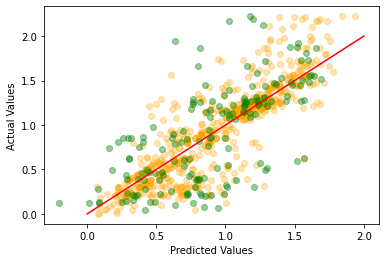

In [33]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [34]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 14:43:03,375] A new study created in memory with name: svm_parameter_opt
[I 2023-08-15 14:43:03,384] Trial 0 finished with value: -0.24806912847924784 and parameters: {'C': 41.59030504710364, 'epsilon': 0.32177569674826945, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: -0.24806912847924784.
[I 2023-08-15 14:43:43,542] Trial 1 finished with value: 0.2261331631162725 and parameters: {'C': 78.50186806231865, 'epsilon': 0.031060944178749116, 'kernel': 'linear', 'degree': 5}. Best is trial 1 with value: 0.2261331631162725.
[I 2023-08-15 14:43:43,550] Trial 2 finished with value: -0.24806912847924784 and parameters: {'C': 19.385448902849156, 'epsilon': 0.3290995986668622, 'kernel': 'poly', 'degree': 2}. Best is trial 1 with value: 0.2261331631162725.
[I 2023-08-15 14:43:44,147] Trial 3 finished with value: -95.72824495310209 and parameters: {'C': 31.050816259467606, 'epsilon': 0.0465543994115367, 'kernel': 'poly', 'degree': 4}. Best is trial 1 with value: 0.2261331

Best r2:  0.4623906996679553
Best trial: {'C': 0.2766385080144353, 'epsilon': 0.011024641706762085, 'kernel': 'rbf', 'degree': 4}


In [35]:
optuna.visualization.plot_parallel_coordinate(study)

In [36]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.2766385080144353, 'epsilon': 0.011024641706762085, 'kernel': 'rbf', 'degree': 4}


In [37]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=0.2766385080144353, degree=4, epsilon=0.011024641706762085)

In [38]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [39]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.05087763031640901
Test RMSE:  0.06543956363057017


In [40]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.6357959125936812
Test R2:  0.4378691464224581


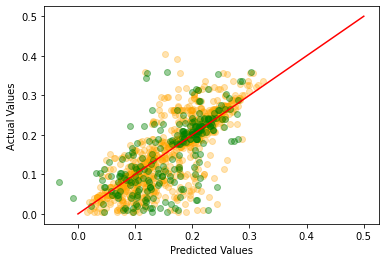

In [41]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [42]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=1000)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-15 14:49:57,868] A new study created in memory with name: svm_parameter_opt
[I 2023-08-15 14:49:58,443] Trial 0 finished with value: 0.4634061169845099 and parameters: {'C': 6.364233117883729, 'epsilon': 0.3947932640353612, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.4634061169845099.
[I 2023-08-15 14:49:58,576] Trial 1 finished with value: 0.43377067217346976 and parameters: {'C': 0.8458388931366112, 'epsilon': 0.012718883918592539, 'kernel': 'poly', 'degree': 1}. Best is trial 0 with value: 0.4634061169845099.
[I 2023-08-15 14:50:04,048] Trial 2 finished with value: 0.47708939801747396 and parameters: {'C': 40.164381453796985, 'epsilon': 0.011385687930861088, 'kernel': 'linear', 'degree': 4}. Best is trial 2 with value: 0.47708939801747396.
[I 2023-08-15 14:50:04,219] Trial 3 finished with value: 0.6558969460828289 and parameters: {'C': 1.7521668365958274, 'epsilon': 0.03158128785043059, 'kernel': 'poly', 'degree': 3}. Best is trial 3 with value: 0.6558

Best r2:  0.7405857361486966
Best trial: {'C': 4.955973979537821, 'epsilon': 0.048306873975667915, 'kernel': 'rbf', 'degree': 1}


In [43]:
optuna.visualization.plot_parallel_coordinate(study)

In [44]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 4.955973979537821, 'epsilon': 0.048306873975667915, 'kernel': 'rbf', 'degree': 1}


In [45]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=4.955973979537821, degree=1, epsilon=0.048306873975667915)

In [46]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [47]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.4309853190656843
Test RMSE:  0.5890187012846446


In [48]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.8738663646868516
Test R2:  0.7590357643426608


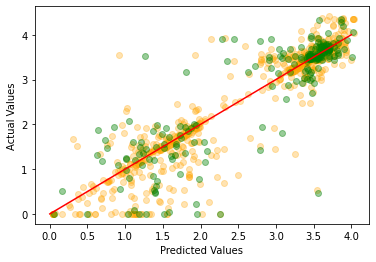

In [49]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()